重新运行一个 notebook 的最快方式是“Kernel -- Restart & Run All”。

笔记：用了 `%timeit` 后整个 cell 里的变量就变成局部变量了。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
%matplotlib inline
import scipy.misc
import Image
import scipy.io
import os


# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples/hed/
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

In [2]:
print np.__version__

1.11.0


In [3]:
data_root = caffe_root + 'data/HED-BSDS/'
with open(data_root+'test.lst') as f: # 图片路径
    test_lst = f.readlines()

test_lst = [data_root+x.strip() for x in test_lst]
print "there are {} images, and the first five are: ".format(len(test_lst)), test_lst[:5];

there are 200 images, and the first five are:  ['../../data/HED-BSDS/test/100007.jpg', '../../data/HED-BSDS/test/100039.jpg', '../../data/HED-BSDS/test/100099.jpg', '../../data/HED-BSDS/test/10081.jpg', '../../data/HED-BSDS/test/101027.jpg']


In [4]:
x = [1, 2, 3];
print x[::-1] # reverse
print x

temp_im = Image.open(test_lst[0])
temp_in = np.array(temp_im, dtype=np.float32)
print temp_in.shape
print type(temp_in)
print temp_im.size
print temp_in[0, 0, 0]
print type(temp_in[0, 0, 0])

[3, 2, 1]
[1, 2, 3]
(321, 481, 3)
<type 'numpy.ndarray'>
(481, 321)
55.0
<type 'numpy.float32'>


In [5]:
im_lst = []
for i in range(0, len(test_lst)):
    im = Image.open(test_lst[i])
    in_ = np.array(im, dtype=np.float32)
    in_ = in_[:,:,::-1]
    in_ -= np.array((104.00698793,116.66876762,122.67891434))
    im_lst.append(in_)

In [6]:
#Visualization
def plot_single_scale(scale_lst, size):
    pylab.rcParams['figure.figsize'] = size, size/2
    
    plt.figure()
    for i in range(0, len(scale_lst)):
        s=plt.subplot(1,5,i+1)
        plt.imshow(1-scale_lst[i], cmap = cm.Greys_r)
        s.set_xticklabels([])
        s.set_yticklabels([])
        s.yaxis.set_ticks_position('none')
        s.xaxis.set_ticks_position('none')
    plt.tight_layout()

In [7]:
entry = (1, 0)
x = np.array([
    [1, 2],
    [3, 4]
]);
print x
# *?

idx = 10

# 要检测的图像
in_ = im_lst[idx]
in_ = in_.transpose((2,0,1))
print in_.shape

# im_lst[1, 2].shape ==  im_lst[1, *(2)].shape

# python 3
# print(*[1], *[2], 3)
# 1 2 3
# dict(**{'x': 1}, y=2, **{'z': 3})
# {'x': 1, 'y': 2, 'z': 3}

[[1 2]
 [3 4]]
(3, 481, 321)


In [8]:
#remove the following two lines if testing with cpu
caffe.set_mode_gpu()
caffe.set_device(0)
# load net
model_root = caffe_root + 'examples/hed/'
# hed_pre

mymodel = model_root + 'hed_pretrained_bsds.caffemodel'
# mymodel = model_root+'hed_iter_100000.caffemodel'
net = caffe.Net(model_root+'deploy.prototxt', mymodel, caffe.TEST)

# shape for input (data blob is [n, k, h, w]), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_

print "in_.shape: {}".format(in_.shape)
print "net.blobs['data'].data.shape: {}, diff.shape: {}".format(net.blobs['data'].data.shape,
                                                               net.blobs['data'].diff.shape)
print "image num: {}".format(len(net.blobs['data'].data[0,:,0,0]))
print len(net.blobs['data'].data)

in_.shape: (3, 481, 321)
net.blobs['data'].data.shape: (1, 3, 481, 321), diff.shape: (1, 3, 481, 321)
image num: 3
1


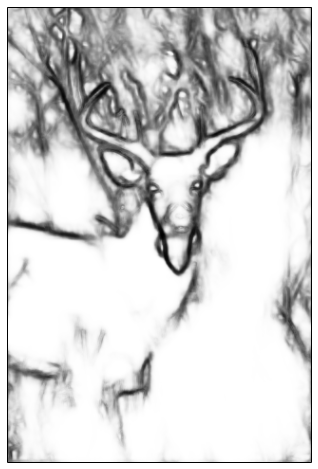

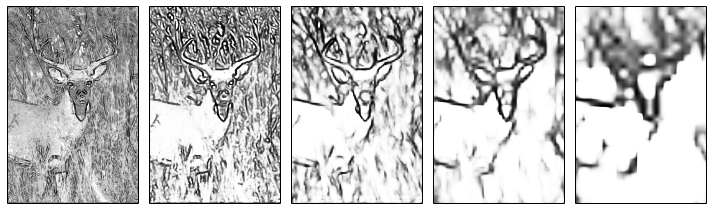

In [9]:
# run net and take argmax for prediction
net.forward()
out1 = net.blobs['sigmoid-dsn1'].data[0][0,:,:]
out2 = net.blobs['sigmoid-dsn2'].data[0][0,:,:]
out3 = net.blobs['sigmoid-dsn3'].data[0][0,:,:]
out4 = net.blobs['sigmoid-dsn4'].data[0][0,:,:]
out5 = net.blobs['sigmoid-dsn5'].data[0][0,:,:]
fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]

scale_lst = [fuse]
plot_single_scale(scale_lst, 22)
scale_lst = [out1, out2, out3, out4, out5]
plot_single_scale(scale_lst, 10)